# Forecasting

## Introduction 

This Jupyter Notebook is adapted from the lecture about Series Forecasting with ARIMA. 

Time series provide the opportunity to forecast future values. Based on previous values, time series can be used to forecast trends in economics, weather, and capacity planning, to name a few. The specific properties of time-series data mean that specialized statistical methods are usually required.

In this notebook we will aim to produce reliable forecasts of time series related to the cryptocurrency Bitcoin. We will begin by introducing concepts of autocorrelation, stationarity, seasonality and proceed to apply one of the most commonly useed method for time-series forecasting, known as **ARIMA**. 

An ARIMA model is a class of statistical model for analyzing and forecasting time series data.

**ARIMA** is an acronym that stands for **AutoRegressive Integrated Moving Average**. It is a generalization of the simpler **AutoRegressive Moving Average** and adds the notion of integration.
This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:
* **AR: Autoregression**. A model that uses the dependent relationship between an observation and some number of lagged observations.
* **I: Integrated**. The use of differencing of raw observations (i.e. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
* **MA: Moving Average**. A model that uses the dependency between an observation and residual errors from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter.
A standard notation is used of `ARIMA(p,d,q)` where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:
* `p`: The number of lag observations included in the model, also called the lag order.

* `d`: The number of times that the raw observations are differenced, also called the degree of differencing.

* `q`: The size of the moving average window, also called the order of moving average.

One of the methods available in Python to model and predict future points of a time series is known as **SARIMAX**, which stands for **Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors**. 

First, we will show the versions of these libraries (that is always wise to do in case you have to report problems running the notebook) and use the inline plotting mode statement.

In [1]:
import IPython
import numpy as np # linear algebra
import pandas as pd
import warnings
import itertools
import statsmodels
import statsmodels.api as sm # statistics
import matplotlib 
import matplotlib.pyplot as plt # for plotting faces 
import seaborn as sns

import yfinance as yf # yahoo finance provider extract the bitcoin prices

import requests # request for the test real-time data
import json

%matplotlib inline

print('IPython version:', IPython.__version__)
print('yfinance version:', yf.__version__)
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('seabord version:', sns.__version__)
print('statsmodels version:', statsmodels.__version__)
print('matplotlib version:', matplotlib.__version__)

IPython version: 7.19.0
yfinance version: 0.1.59
numpy version: 1.19.2
pandas version: 1.1.3
seabord version: 0.11.0
statsmodels version: 0.12.2
matplotlib version: 3.3.2


## The Time Series Forecasting steps: overview

* Preparing the data, 
* Analysing and visualising the data, 
* Cleaning the data, 
* The ARIMA Time Series Model,
* Parameter Selection for the ARIMA Time Series Model,
* Fitting an ARIMA Time Series Model, 
* Validating Forecasts, 
* Producing and Visualizing Forecasts.
* Save the Models

## Step 1: Preparing the data

In this notebook, we are going to use Yahoo Finance provider to extract the latest historical data for cryptocurrencies such as Bitcoin (BTC-USD), Ethereum (ETH-USD) and Dogecoin (DOGE-USD). More info at: https://finance.yahoo.com/cryptocurrencies/

### Background: Dataset Context

Bitcoin is the longest running and most well known cryptocurrency, first released as open source in 2009 by the anonymous Satoshi Nakamoto. Bitcoin serves as a decentralized medium of digital exchange, with transactions verified and recorded in a public distributed ledger (the blockchain) without the need for a trusted record keeping authority or central intermediary. Transaction blocks contain a SHA-256 cryptographic hash of previous transaction blocks, and are thus "chained" together, serving as an immutable record of all transactions that have ever occurred. As with any currency/commodity on the market, bitcoin trading and financial instruments soon followed public adoption of bitcoin and continue to grow. Included here is historical bitcoin market data at 1-min intervals for select bitcoin exchanges where trading takes place.

### Download the dataset

In [2]:
df = yf.download("BTC-USD")
df.to_csv('data/bitcoin.csv')
data_bitcoin = pd.read_csv('data/bitcoin.csv', header=0, index_col='Date', parse_dates=True)

### Explore the dataset

Get a first impression of the dataset by showing the first 5 rows and lat 5 rows of the DataFrame. More details in the Exploratory Data Analysis for Bitcoin from the file folder. 

In [3]:
data_bitcoin.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
data_bitcoin.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-06,57441.308594,58363.316406,55382.507812,56396.515625,56396.515625,69523285106
2021-05-07,56413.953125,58606.632812,55321.847656,57356.402344,57356.402344,68434023376
2021-05-08,57352.765625,59464.613281,56975.210938,58803.777344,58803.777344,65382980634
2021-05-09,58877.390625,59210.882812,56482.003906,58232.316406,58232.316406,65906690347
2021-05-10,58283.898438,59452.210938,57313.062500,57313.062500,57313.062500,60038877184


Method `pandas.DataFrame.info()` prints information about a DataFrame including the index dtype and columns, non-null values, and memory usage. See https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html.

In [5]:
data_bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2424 entries, 2014-09-17 to 2021-05-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2424 non-null   float64
 1   High       2424 non-null   float64
 2   Low        2424 non-null   float64
 3   Close      2424 non-null   float64
 4   Adj Close  2424 non-null   float64
 5   Volume     2424 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 132.6 KB


Method `pandas.DataFrame.describe()` generates descriptive statistics. These include central tendency, dispersion,
and shape of a dataset's distribution, excluding NaN values. 
See https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html#pandas.DataFrame.describe

In [6]:
data_bitcoin.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,2.424000e+03
mean,7264.383626,7467.329574,7053.836067,7286.718059,7286.718059,1.210952e+10
std,11168.437228,11510.882994,10802.196000,11211.580041,11211.580041,1.907463e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,457.368492,462.603989,453.210510,457.509499,457.509499,6.820313e+07
50%,4170.250000,4316.177002,4061.894775,4178.330078,4178.330078,3.917430e+09
75%,9108.849854,9275.408203,8860.103027,9122.761963,9122.761963,1.810460e+10
max,63523.753906,64863.097656,62208.964844,63503.457031,63503.457031,3.509679e+11


### Indexing with Time-series data

When working with time-series data in Python we should ensure that dates are used as an index, so we should make sure to always check for that, which we can do by running the following:

In [7]:
data_bitcoin.index

DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2021-05-01', '2021-05-02', '2021-05-03', '2021-05-04',
               '2021-05-05', '2021-05-06', '2021-05-07', '2021-05-08',
               '2021-05-09', '2021-05-10'],
              dtype='datetime64[ns]', name='Date', length=2424, freq=None)

The `dtype=datetime[ns]` field confirms that our index is made of date stamp objects, while `length=2424` and `freq='W-SAT'` tells us that we have 2,424 weekly date stamps.

## Step 2: Analysing and visualising the data

Plot the bitcoin price versus date.

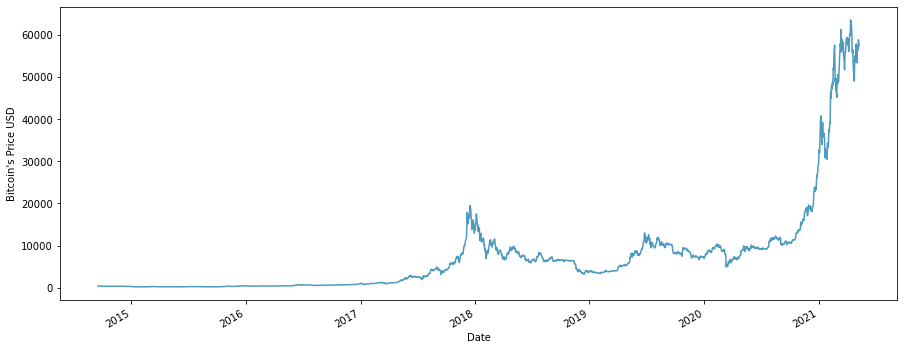

In [8]:
ax = data_bitcoin.Close.plot(figsize=(15, 6),label='Close',color='#4d9bbf')
ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin\'s Price USD')

plt.show()

It can be observed that the Bitcoin's price is increasing. But what is driving this growth? It turns out there are a wide variety of factors that continue to make Bitcoin rise in value.

### Key  Takesaways
* Bitcoin broke a key resistance level making investors believe there is further upside.
* Publicly traded companies purchasing Bitcoin shows a high level of confidence in its appreciation.
* Traded companies convert cash in their treasuries to Bitcoin as a store-of-value. 

Let's see more insight in the last year, plot the Bitcoin's close prices for 2021

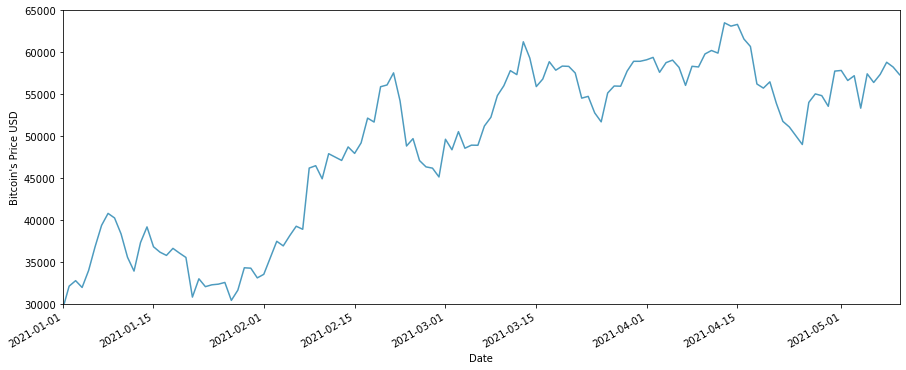

In [9]:
ax = data_bitcoin.Close.plot(figsize=(15, 6),label='Close',color='#4d9bbf')

# Put Lables
ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin\'s Price USD')

# Date range
plt.xlim(['2021-01-01','2021-05-10'])

# Closed price 
plt.ylim([30000,65000])
plt.show()

### What determines bitcoin’s price?

The price of a bitcoin is determined by supply and demand. When demand for bitcoins increases, the price increases, and when demand falls, the price falls. There is only a limited number of bitcoins in circulation and new bitcoins are created at a predictable and decreasing rate, which means that demand must follow this level of inflation to keep the price stable. Because Bitcoin is still a relatively small market compared to what it could be, it doesn't take significant amounts of money to move the market price up or down, and thus the price of a bitcoin is still very volatile.

### Stationarity

Let’s prepare the data for modeling by making the data stationary. We do this by simply differencing the data and testing for stationarity by using something called the Dickey-Fuller test. We are aiming for a P-Value of less than the critical value of 5%, or simply trying to get as close to zero as possible. 

[[source]](https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/)

**ADF (Augmented Dickey Fuller) Test**

The Dickey Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. 

[[source]](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html)

In [10]:
from statsmodels.tsa.stattools import adfuller

def get_stationarity_adfuller_test():
    # Converting the data to a logarithmic scale
    bc_log = pd.DataFrame(np.log(data_bitcoin.Close))

    # Differencing the log values
    log_diff = bc_log.diff().dropna()

    # Using the Dickey-Fuller test to check for stationarity
    dftest = adfuller(log_diff.Close, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    print (dfoutput)

In [11]:
# Apply Dickey-Fuller test
get_stationarity_adfuller_test()

Test Statistic                -1.488251e+01
p-value                        1.601514e-27
# Lags Used                    9.000000e+00
Number of Observations Used    2.413000e+03
Critical Value (1%)           -3.433063e+00
Critical Value (5%)           -2.862739e+00
Critical Value (10%)          -2.567408e+00
dtype: float64


If the `p-value` of the test is less than the significance level (0.05) than we can reject the null hypothesis and infer that the time series is indeed stationary. In our case it seems that we get p-value of 1.6. It is clear that this price series is not stationary, because p value is really high. 

We will need to find the order of differencing. We will need to substract and possibly differencing multiple times. That's `d` in ARIMA model.

**KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test**

KPSS is another test for checking the stationarity of a time series (slightly less popular than the Dickey Fuller test). The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

[[source]](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html)

In [12]:
from statsmodels.tsa.stattools import kpss
warnings.filterwarnings("ignore") # specify to ignore warning messages

def get_stationarity_kpss_test():
    # Converting the data to a logarithmic scale
    bc_log = pd.DataFrame(np.log(data_bitcoin.Close))

    # Differencing the log values
    log_diff = bc_log.diff().dropna()

    # Using the KPSS test to check for stationarity
    kpsstest = kpss(log_diff.Close, regression='c', nlags="auto")
    
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','# Lags Used'])
    
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
        
    print (kpss_output)

In [13]:
# Apply KPSS test
get_stationarity_kpss_test()

Test Statistic           0.210498
p-value                  0.100000
# Lags Used              5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


## Step 3: Cleaning the data
Let’s preprocess our data a little bit before moving forward. Weekly data can be tricky to work with since it’s a briefer amount of time, so let’s use monthly averages instead. We’ll make the conversion with the resample function. For simplicity, we can also use the `fillna()` function to ensure that we have no missing values in our time series.

In [14]:
data_bitcoin = data_bitcoin['Close'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
data_bitcoin = data_bitcoin.fillna(data_bitcoin.bfill())

print(data_bitcoin)

Date
2014-09-01      407.182428
2014-10-01      364.148873
2014-11-01      366.099799
2014-12-01      341.267871
2015-01-01      248.782547
                  ...     
2021-01-01    34703.053427
2021-02-01    46306.798968
2021-03-01    54998.008695
2021-04-01    57206.720052
2021-05-01    57051.904297
Freq: MS, Name: Close, Length: 81, dtype: float64


Let’s explore this time series e as a data visualization:

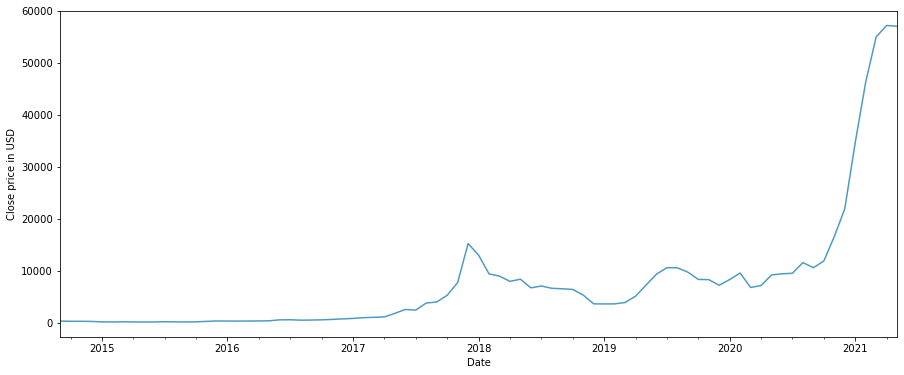

In [15]:
ax = data_bitcoin.plot(figsize=(15, 6),color='#4d9bbf')
ax.set_xlabel('Date')
ax.set_ylabel('Close price in USD')

plt.show()

Some distinguishable patterns appear when we plot the data. The time series has an obvious seasonality pattern, as well as an overall increasing trend.

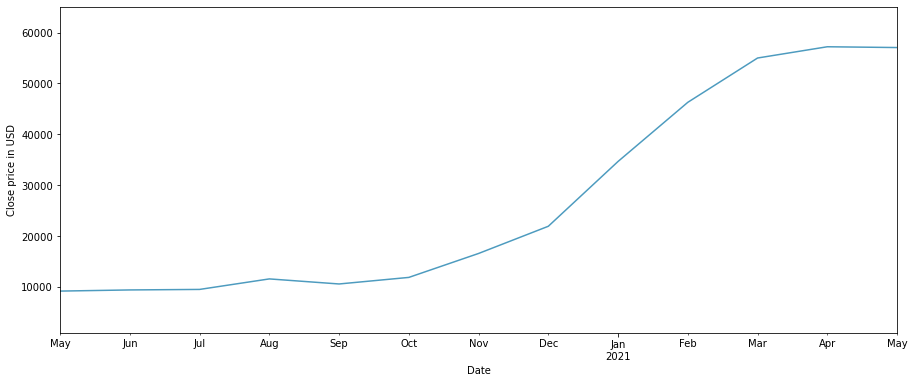

In [16]:
ax = data_bitcoin.plot(figsize=(15, 6), color='#4d9bbf')

# Put Lables
ax.set_xlabel('Date')
ax.set_ylabel('Close price in USD')

# Date range
plt.xlim(['2020-05-01','2021-05-10'])

# Closed price 
plt.ylim([1000,65000])
plt.show()

### Autocorrelation

Autocorrelation is the correlation of a time series with the same time series lagged. It summarizes the strength of a relationship with an observation in a time series with observations at prior time steps.

We create autocorrelation factor (ACF) and partial autocorrelation factor (PACF) plots to identify patterns in the above data which is stationary on both mean and variance. The idea is to identify presence of AR and MA components in the residuals.

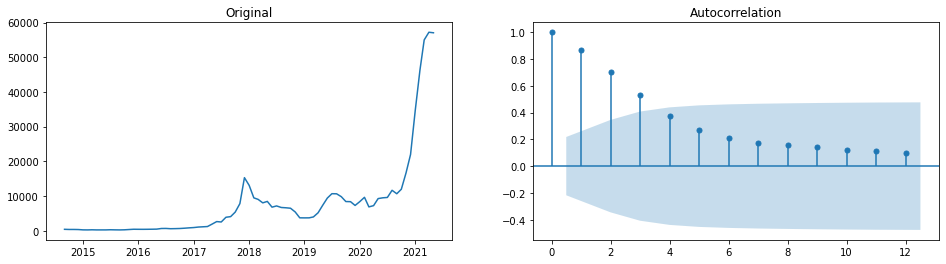

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(data_bitcoin)
ax1.set_title("Original")

# add ; at the end of the plot function so it's not duplicated
plot_acf(data_bitcoin, ax=ax2, lags=12);

### Degree of differencing

It generally refers to `d` in ARIMA. The number of times that the raw observations are differenced, also called the degree of differencing.

We can use the `pmdarima` package to get the number of differencing.

In [18]:
from pmdarima.arima.utils import ndiffs

ndiffs(data_bitcoin, test="adf")

2

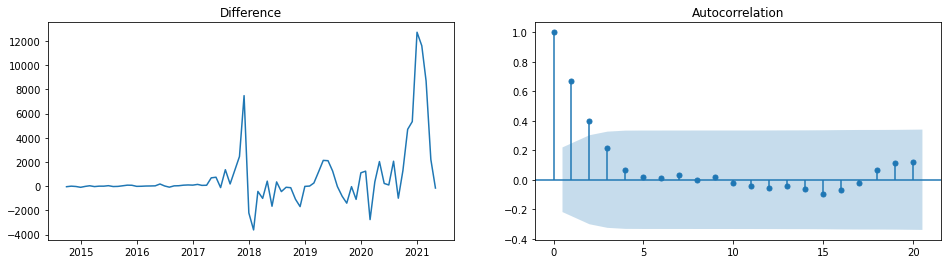

In [19]:
# Differentiate in a range
for i in range(0, ndiffs(data_bitcoin, test="adf")):
    diff = data_bitcoin.diff().dropna()

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference")
plot_acf(diff, ax=ax2);

### Auto Regressive (AR)

`p` is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors. We can find the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot. The partial autocorrelation represents the correlation between the series and its lags.

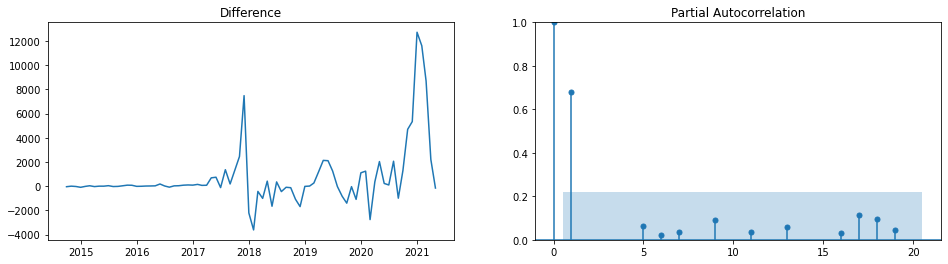

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf

diff = data_bitcoin.diff().dropna()

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

### Moving Average (MA)

`q` is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model. We will look at the ACF plot for the number of MA terms.

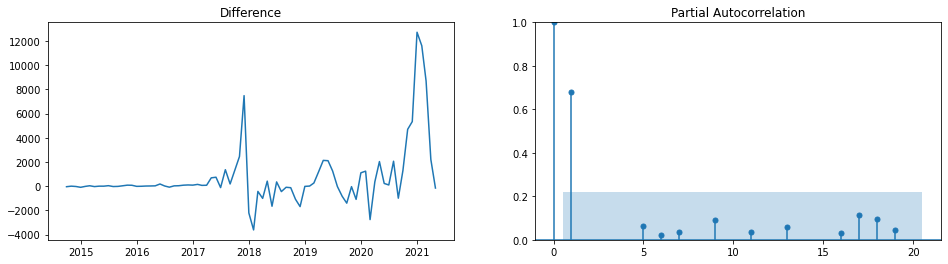

In [21]:
from statsmodels.graphics.tsaplots import plot_acf

diff = data_bitcoin.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

We can observe that the PACF lag 1 is way above the significance line. 

### Stationarity check and Seasonal decomposition 

If a time series is stationary, it implies the lack of broad trends (changes in mean and variance over time) in the data. This is important as a consideration in time series forecasting.

[[source]](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)

Dickey–Fuller test: p=0.889098


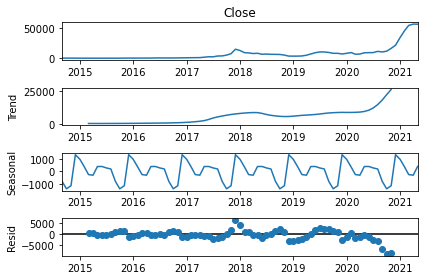

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(data_bitcoin).plot()
print("Dickey–Fuller test: p=%f" % adfuller(data_bitcoin)[1])
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

There is a positive correlation with the 12 lags that is perhaps significant for the first 2-3 lags. A good starting point for the AR parameter of the model may be 3.

In [23]:
# Drop Nan values
data_bitcoin.dropna(inplace=True)

## Step 4:  The ARIMA Time Series Model
One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for AutoregRessive Integrated Moving Average. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.

There are three distinct integers (`p`, `d`, `q`) that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation `ARIMA(p, d, q)`. Together these three parameters account for seasonality, trend, and noise in datasets:

* `p` is the *auto-regressive* part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
* `d` is the *integrated* part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
* `q` is the *moving average* part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

When dealing with seasonal effects, we make use of the *seasonal* ARIMA, which is denoted as `ARIMA(p,d,q)(P,D,Q)s`. Here, `(p, d, q)` are the non-seasonal parameters described above, while `(P, D, Q)` follow the same definition but are applied to the seasonal component of the time series. The term `s` is the periodicity of the time series (`4` for quarterly periods, `12` for yearly periods, etc.).

The seasonal ARIMA method can appear daunting because of the multiple tuning parameters involved. In the next section, we will describe how to automate the process of identifying the optimal set of parameters for the seasonal ARIMA time series model.

[[source]](https://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html)

### Fitting the ARIMA model

In [24]:
from statsmodels.tsa.arima_model import ARIMA

# ARIMA Model
model_arima = ARIMA(data_bitcoin, order=(1,2,1))
results_arima = model_arima.fit(disp=0)

print(results_arima.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                   79
Model:                 ARIMA(1, 2, 3)   Log Likelihood                -708.520
Method:                       css-mle   S.D. of innovations           1862.897
Date:                Mon, 10 May 2021   AIC                           1429.039
Time:                        16:31:23   BIC                           1443.256
Sample:                    11-01-2014   HQIC                          1434.735
                         - 05-01-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             35.8395     21.498      1.667      0.095      -6.296      77.975
ar.L1.D2.Close     0.5054      0.222      2.278      0.023       0.071       0.940
ma.L1.D2.Close    -0.8101      0.232

(array([7.68440174e-06, 0.00000000e+00, 2.30532052e-05, 9.22128209e-05,
        3.30429275e-04, 1.22950428e-04, 1.53688035e-05, 0.00000000e+00,
        7.68440174e-06, 7.68440174e-06]),
 array([-7723.18581827, -6075.92318482, -4428.66055137, -2781.39791792,
        -1134.13528447,   513.12734898,  2160.38998243,  3807.65261588,
         5454.91524933,  7102.17788278,  8749.44051622]),
 <BarContainer object of 10 artists>)

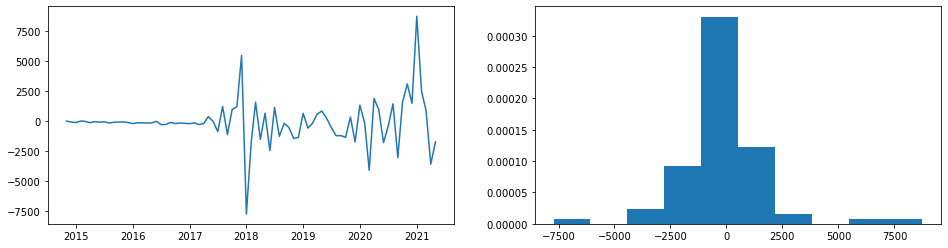

In [25]:
# Plot the ARIMA errors
residuals = pd.DataFrame(results_arima.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

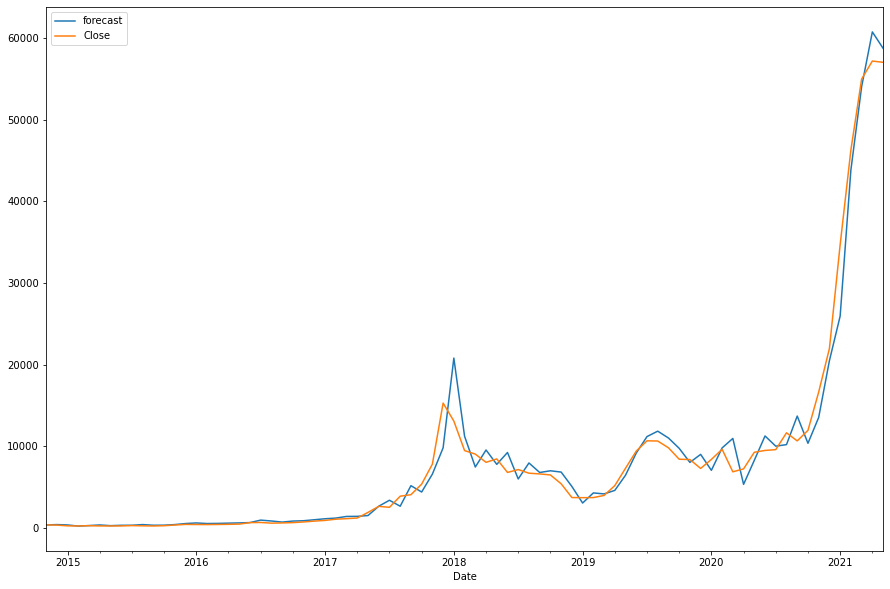

In [26]:
# Actual vs Fitted
results_arima.plot_predict(dynamic=False);

## Step 5: Parameter Selection for the SARIMAX and ARIMA Time Series Model

When looking to fit time series data with a seasonal ARIMA model, our first goal is to find the values of `ARIMA(p,d,q)(P,D,Q)s` that optimize a metric of interest. There are many guidelines and best practices to achieve this goal, yet the correct parametrization of ARIMA models can be a painstaking manual process that requires domain expertise and time. Other statistical programming languages such as `R` provide automated ways to solve this issue (https://www.rdocumentation.org/packages/forecast/versions/7.3/topics/auto.arima), but those have yet to be ported over to Python. In this section, we will resolve this issue by writing Python code to programmatically select the optimal parameter values for our `ARIMA(p,d,q)(P,D,Q)s` time series model.

We will use a “grid search” to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the `SARIMAX()` function from the `statsmodels` module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest. Let’s begin by generating the various combination of parameters that we wish to assess:

[[source]](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)

In [27]:
from statsmodels.tsa.arima_model import ARIMA
import itertools

# Grid Search
p = d = q = range(0,2) # p, d, and q can be either 0, 1, or 2
pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q

combs = {} # stores aic and order pairs
aics = [] # stores aics

# Grid Search continued
for combination in pdq:
    try:
        model_arima = ARIMA(data_bitcoin, order=combination) # create all possible models
        model_arima = model_arima.fit()
        combs.update({model_arima.aic : combination}) # store combinations
        aics.append(model_arima.aic)
    except:
        continue
        
best_aic = min(aics)

In [28]:
# ARIMA Model Creation and Forecasting
model_arima = ARIMA(data_bitcoin, order=combs[best_aic])
model_arima = model_arima.fit()

model_arima.forecast(7)[0]

array([57175.88562863, 57484.68454194, 57916.0010139 , 58428.53569059,
       58994.910787  , 59596.97727556, 60222.70397109])

We can now use the triplets of parameters defined above to automate the process of training and evaluating ARIMA models on different combinations. In Statistics and Machine Learning, this process is known as grid search (or hyperparameter optimization) for model selection.

When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. We will use the `AIC` (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using `statsmodels`. The `AIC` measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest `AIC` value.

The code chunk below iterates through combinations of parameters and uses the `SARIMAX` function from `statsmodels` to fit the corresponding Seasonal ARIMA model. Here, the `order` argument specifies the `(p, d, q)` parameters, while the `seasonal_order` argument specifies the `(P, D, Q, S)` seasonal component of the Seasonal ARIMA model. After fitting each `SARIMAX()` model, the code prints out its respective `AIC` score.

 `SARIMAX` is much like `ARIMA`, but a little more complicated. Not only do you have to use a loop and grid search for the optimal values of p, d, and q, but you have to also use a nested loop and grid search for the seasonal values for p, d, and q. There are also many more parameters in the SARIMAX function.
 
 `SARIMAX` is used on data sets that have seasonal cycles. The difference between `ARIMA` and `SARIMAX` is the seasonality and exogenous factors (seasonality and regular `ARIMA` don’t mix well) Below is an example of creating a `SARIMAX` model

In [29]:
# Grid Search
p = d = q = range(0,2) # p, d, and q can be either 0, 1, or 2
pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q 

p2 = d2 = q2 = range(0, 2) # second set of p's, d's, and q's
pdq2 = list(itertools.product(p2,d2,q2)) # simular too code above but for seasonal parameters
s = 12 # here I use twelve but the number here is representative of the periodicty of the seasonal cycle

pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]

combs = {}
aics = []

# Grid Search Continued
for combination in pdq:
    for seasonal_combination in pdqs2:
        try:
            model_sarimax = sm.tsa.statespace.SARIMAX(data_bitcoin, order=combination, seasonal_order=seasonal_combination,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            model_sarimax = model_sarimax.fit()
            combs.update({model_sarimax.aic : [combination, seasonal_combination]})
            aics.append(model_sarimax.aic)
            
        except:
            continue
            
best_aic = min(aics)

In [30]:
# SARIMAX Model Creation and Forecasting
model_sarimax = sm.tsa.statespace.SARIMAX(data_bitcoin, order=combs[best_aic][0], seasonal_order=combs[best_aic][1],
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
model_sarimax = model_sarimax.fit()
model_sarimax.forecast(7)

2021-06-01    59502.180675
2021-07-01    63271.602548
2021-08-01    67204.143327
2021-09-01    70827.529848
2021-10-01    74881.664231
2021-11-01    79568.995504
2021-12-01    84582.200405
Freq: MS, Name: predicted_mean, dtype: float64

## Step 6: Fitting a ARIMA and SARIMAX Time Series Model and Forecast
Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

**ARIMA**

We’ll start by splitting the model into test and train sets and plugging the optimal parameter values into a new `ARIMA` model:

In [31]:
# Split the datasets
percentage = int(len(data_bitcoin) * 0.8)
train_arima = data_bitcoin[:percentage]
test_arima = data_bitcoin[percentage:]

print("ARIMA train set: {}\nARIMA test set: {}".format(len(train_arima), len(test_arima)))

ARIMA train set: 64
ARIMA test set: 17


In [32]:
model_arima = ARIMA(train_arima, order=(1,2,3))
model_arima = model_arima.fit(disp=0)

print(model_arima.summary().tables[1])

                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.2490     11.119     -0.022      0.982     -22.042      21.544
ar.L1.D2.Close    -0.9185      0.067    -13.676      0.000      -1.050      -0.787
ma.L1.D2.Close     0.2483      0.154      1.612      0.107      -0.054       0.550
ma.L2.D2.Close    -0.9999      0.071    -14.050      0.000      -1.139      -0.860
ma.L3.D2.Close    -0.2484      0.137     -1.818      0.069      -0.516       0.019


**SARIMAX**

Let's continue with the optimal parameter values into a SARIMAX model:

In [33]:
print(model_sarimax.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3368      0.111     -3.022      0.003      -0.555      -0.118
ma.L2         -0.4481      0.146     -3.073      0.002      -0.734      -0.162
ma.S.L12      -1.1459      0.089    -12.879      0.000      -1.320      -0.972
sigma2       5.13e+06   1.23e-08   4.19e+14      0.000    5.13e+06    5.13e+06


The `summary` attribute that results from the output of `SARIMAX` returns a significant amount of information, but we’ll focus our attention on the table of coefficients. The `coef` column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The `P>|z|` column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to `0.05`, so it is reasonable to retain all of them in our model.

[[source]](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)

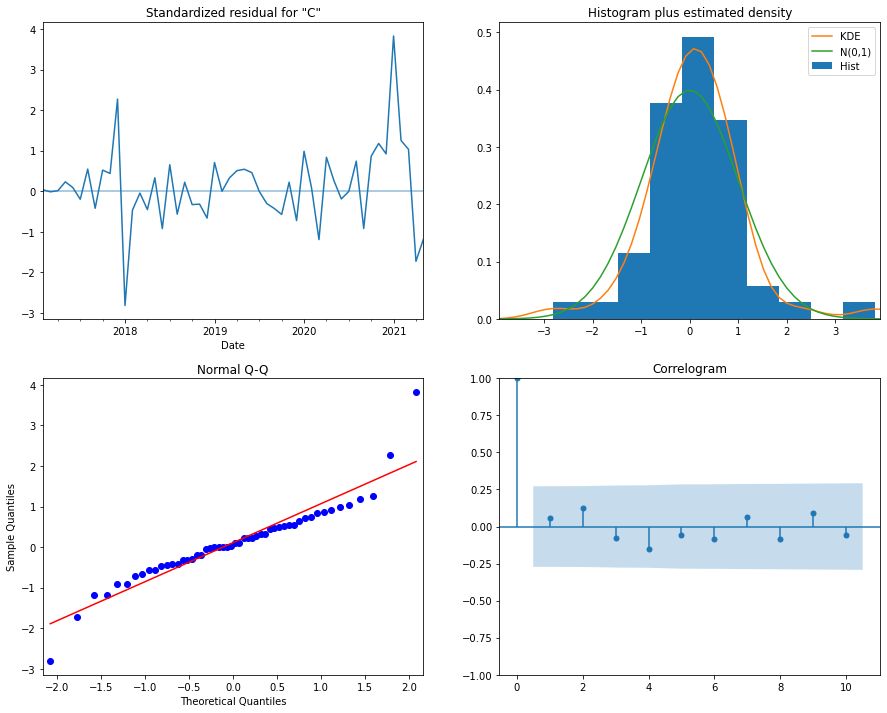

In [34]:
model_sarimax.plot_diagnostics(figsize=(15, 12))
plt.show()

Our main concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the Seasonal ARIMA model does not satisfy these properties, it is an indicator that it can be improved.

   * In the top right plot, we see that the red `KDE` line follows almost close as the `N(0,1)` line (where `N(0,1)`) is the standard notation for a normal distribution with mean `0` and standard deviation of `1`). It seems like a good indication that the residuals are normally distributed.

   * The `QQ-plot` on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with `N(0, 1)`. However, there are some deviations at the start and the end of the line. Again, this should be a strong indication that the residuals are normally distributed.

   * The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

## Step 7: Validating Forecasts SARIMAX

We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. The `get_prediction()` and `conf_int()` attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

We are going to start at January 2021.

The `dynamic=False` argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

In [35]:
pred = model_sarimax.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()

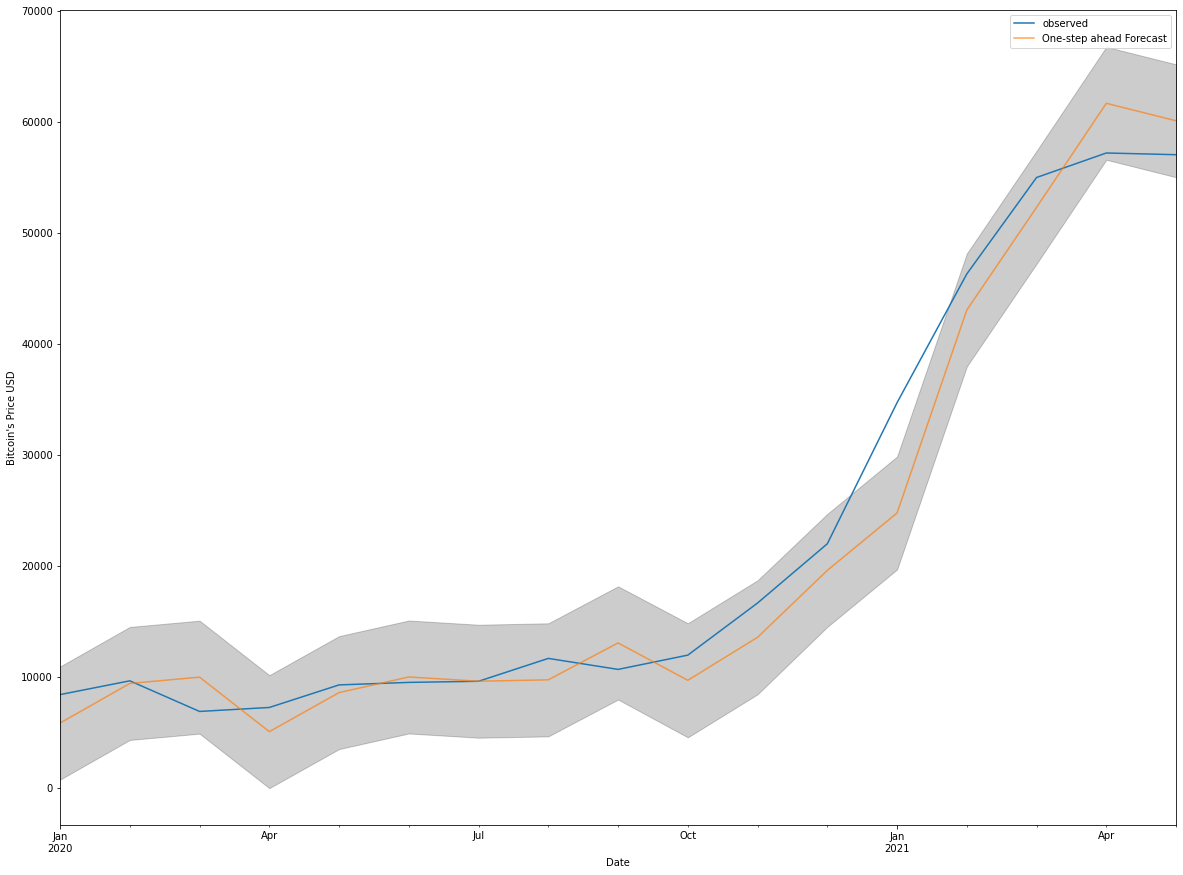

In [36]:
ax = data_bitcoin['2020-01-01':].plot(label='observed', figsize=(20, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin\'s Price USD')
plt.legend()

plt.show()

Overall, our forecast align with the true values, showing the increase trend.

We will use the MSE (Mean Squared Error), which summarizes the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [40]:
from sklearn.metrics import mean_squared_error

bitcoin_forecasted = pred.predicted_mean
bitcoin_truth = data_bitcoin['2020-01-01':]

# Compute the root mean square error
rmse = mean_squared_error(bitcoin_truth, bitcoin_forecasted, squared=False) / 100
print('The Mean Squared Error of our forecasts is {} %'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 34.09 %


 MSE of 0 would that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it not typically possible. However, a better representation of our true predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.
 
In the code chunk below, we specify to start computing the dynamic forecasts and confidence intervals from November 2020.

In [43]:
pred_dynamic = model_sarimax.get_prediction(start=pd.to_datetime('2020-10-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

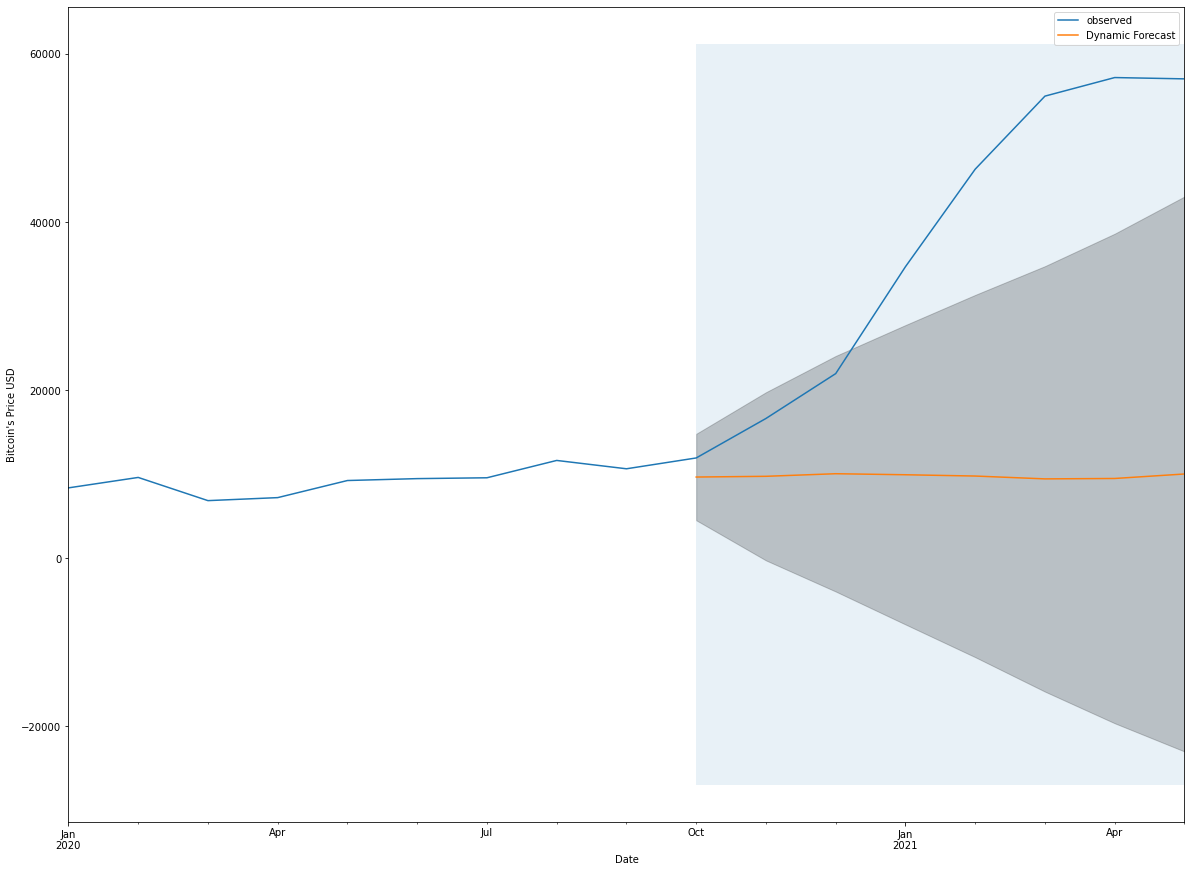

In [44]:
ax = data_bitcoin['2020-01-01':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-10-01'), data_bitcoin.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin\'s Price USD')

plt.legend()
plt.show()

The One-step ahead forecast confirms that this time series model is valid.

## Step 8: Producing and Visualizing Forecasts
In the step, We will use our SARIMAX time series models to forecast future values. The `get_forecast()` attribute of our time series object can compute forecasted values for a specified number of steps ahead. Let's predict 30 steps ahead.

[[source]](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.get_forecast.html)

In [45]:
# Get forecast 30 steps ahead in future
pred_uc = model_sarimax.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

Let's plot the output of this code and visualize the time series and the forecast.

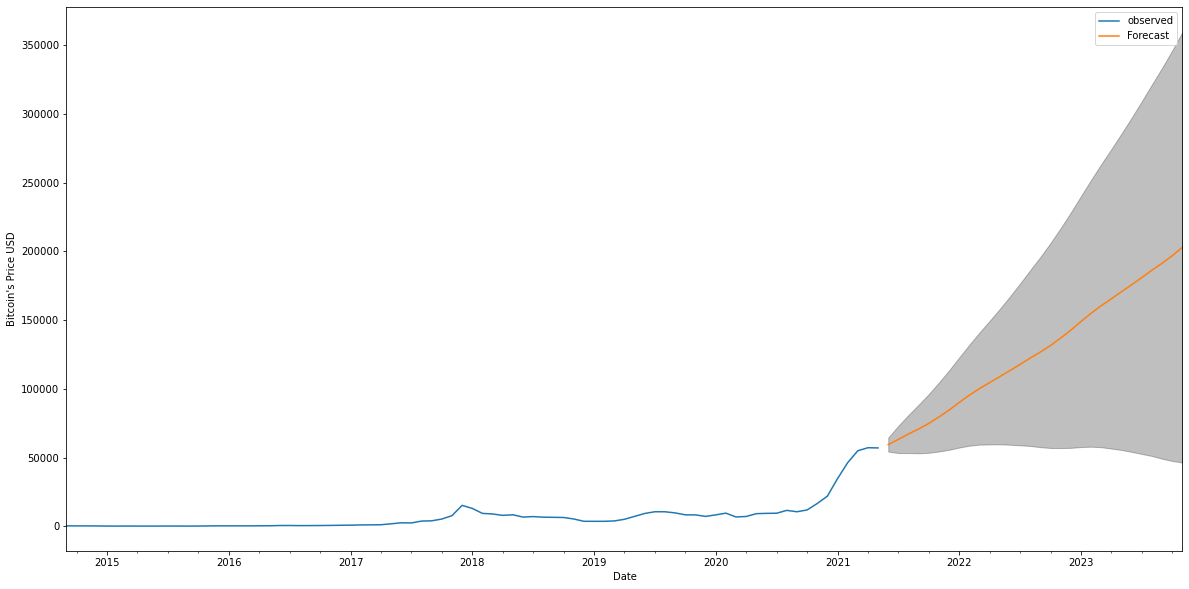

In [46]:
def plot_forecast(pred_uc, pred_ci):
    ax = data_bitcoin.plot(label='observed', figsize=(20, 10))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Bitcoin\'s Price USD')

    plt.legend()
    plt.show()
    
plot_forecast(pred_uc, pred_ci)

## Step 9: Saving the trained Model

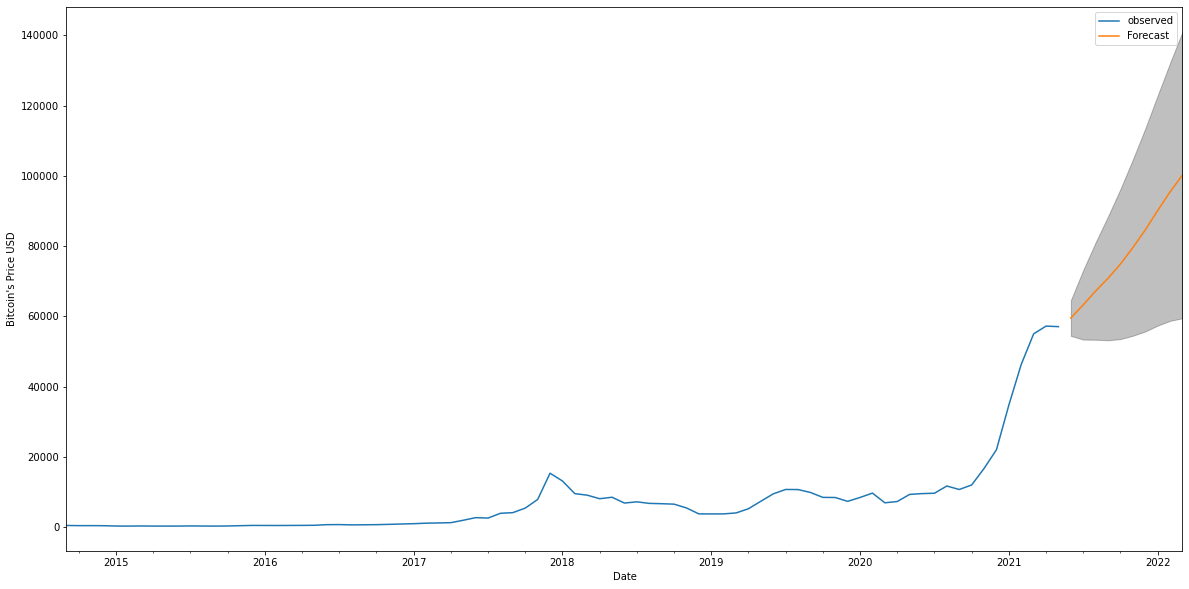

In [48]:
import pickle 

# Save to file in the current working directory
pkl_filename = "pickle_model_sarimax.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model_sarimax, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

# Get forecast 10 steps ahead in future
pred_uc = pickle_model.get_forecast(steps=10)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

# Forecast
plot_forecast(pred_uc, pred_ci)

## Conclusion

In this notebook, we described what to expect from the Bitcoin's price. We made extensive use of the pandas and statsmodels libraries and showed how to run model diagnostics, as well as how to produce forecasts of time series type.

Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. Our forecasts show that the Bitcoin's price is expected to continue increasing at a steady pace for the next months. Considering all of the massive price projections and the forecasts suggest that Bitcoin has a intresting trading future.

## References

[1] ARIMA for time series forecasting with python https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

[2] What is Bitcoin? https://bitcoin.org/en/faq#general

[3] Non stationary time series Python https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/

[4] Predicting prices of bitcoin https://towardsdatascience.com/predicting-prices-of-bitcoin-with-machine-learning-3e83bb4dd35f